In [1]:
# this notebook will look at transient cases for tilting and climate perturbations

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# SET UP GRID ARRAYS
dx = 1000
x = np.arange(0, 100000, dx)
q = x
double_q = 2*x

# set up references to topography
Hstar = 0.1
H = Hstar + np.zeros(len(x))
etab = -H
eta = etab + H

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:25] = 0.000004
beta_sed = np.zeros(len(x))
beta_sed[25:] = 0.000064

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:25] = 0.0001
k_sed = np.zeros(len(x))
k_sed[25:] = 0.001

In [4]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     q,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     k_ig,
                     k_sed,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 850000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt = 0.5 * (0.2 * dx * dx / (c*q[-1])) # time-step size

    for i in range(num_steps):
        
        # lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        # S = 0.001
        
        # calculate e factor
        efac = np.exp(- H / Hstar)
        
        # calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        # calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        # calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[:-1])
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[:-1])
        
        # calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        # calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        # calc grain attrition
        atr = 0.000004 * qs[1:]
        
        # calc change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0
        
        # track total erosion
        total_ero = bedrock_ero - sedimentation_rate
        
        # update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
    return (eta, etab, S, efac, qs, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, 
            atr, sedimentation_rate, H, total_ero)

In [5]:
# up first, run our landscape to steady state

(eta_1, 
etab_1,
S_1,
efac_1,
qs_1,
ero_plucking_ig_1, 
ero_plucking_sed_1,
ero_ab_ig_1,
ero_ab_sed_1,
bedrock_ero_1, 
atr_1, 
sedimentation_rate_1, 
H_1, 
total_ero_1) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H,
                                etab,
                                eta,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed)

In [6]:
# now tilt our landscape
upstream_tilt_factor = np.linspace(45, 1, 100)

eta_tilt = eta_1 + upstream_tilt_factor
etab_tilt = etab_1 + upstream_tilt_factor

In [7]:
# # now check out some post-tilt transient cases

(eta_2, 
etab_2,
S_2,
efac_2,
qs_2,
ero_plucking_ig_2, 
ero_plucking_sed_2,
ero_ab_ig_2,
ero_ab_sed_2,
bedrock_ero_2, 
atr_2, 
sedimentation_rate_2, 
H_2, 
total_ero_2) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_tilt,
                                eta_tilt,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 100000)

eta_2_copy = eta_2.copy()
etab_2_copy = etab_2.copy()
S_2_copy = S_2.copy()
efac_2_copy = efac_2.copy()
qs_2_copy = qs_2.copy()
ero_plucking_ig_2_copy = ero_plucking_ig_2.copy()
ero_plucking_sed_2_copy = ero_plucking_sed_2.copy()
ero_ab_ig_2_copy = ero_ab_ig_2.copy()
ero_ab_sed_2_copy = ero_ab_sed_2.copy()
bedrock_ero_2_copy = bedrock_ero_2.copy()
atr_2_copy = atr_2.copy()
sedimentation_rate_2_copy = sedimentation_rate_2.copy()
H_2_copy = H_2.copy()
total_ero_2_copy = total_ero_2.copy()

(eta_3, 
etab_3,
S_3,
efac_3,
qs_3,
ero_plucking_ig_3, 
ero_plucking_sed_3,
ero_ab_ig_3,
ero_ab_sed_3,
bedrock_ero_3, 
atr_3, 
sedimentation_rate_3, 
H_3, 
total_ero_3) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_tilt,
                                eta_tilt,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 300000)

eta_3_copy = eta_3.copy()
etab_3_copy = etab_3.copy()
S_3_copy = S_3.copy()
efac_3_copy = efac_3.copy()
qs_3_copy = qs_3.copy()
ero_plucking_ig_3_copy = ero_plucking_ig_3.copy()
ero_plucking_sed_3_copy = ero_plucking_sed_3.copy()
ero_ab_ig_3_copy = ero_ab_ig_3.copy()
ero_ab_sed_3_copy = ero_ab_sed_3.copy()
bedrock_ero_3_copy = bedrock_ero_3.copy()
atr_3_copy = atr_3.copy()
sedimentation_rate_3_copy = sedimentation_rate_3.copy()
H_3_copy = H_3.copy()
total_ero_3_copy = total_ero_3.copy()

(eta_4, 
etab_4,
S_4,
efac_4,
qs_4,
ero_plucking_ig_4, 
ero_plucking_sed_4,
ero_ab_ig_4,
ero_ab_sed_4,
bedrock_ero_4, 
atr_4, 
sedimentation_rate_4, 
H_4, 
total_ero_4) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_tilt,
                                eta_tilt,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 500000)

eta_4_copy = eta_4.copy()
etab_4_copy = etab_4.copy()
S_4_copy = S_4.copy()
efac_4_copy = efac_4.copy()
qs_4_copy = qs_4.copy()
ero_plucking_ig_4_copy = ero_plucking_ig_4.copy()
ero_plucking_sed_4_copy = ero_plucking_sed_4.copy()
ero_ab_ig_4_copy = ero_ab_ig_4.copy()
ero_ab_sed_4_copy = ero_ab_sed_4.copy()
bedrock_ero_4_copy = bedrock_ero_4.copy()
atr_4_copy = atr_4.copy()
sedimentation_rate_4_copy = sedimentation_rate_4.copy()
H_4_copy = H_4.copy()
total_ero_4_copy = total_ero_4.copy()

(eta_5, 
etab_5,
S_5,
efac_5,
qs_5,
ero_plucking_ig_5, 
ero_plucking_sed_5,
ero_ab_ig_5,
ero_ab_sed_5,
bedrock_ero_5, 
atr_5, 
sedimentation_rate_5, 
H_5, 
total_ero_5) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_tilt,
                                eta_tilt,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 700000)

eta_5_copy = eta_5.copy()
etab_5_copy = etab_5.copy()
S_5_copy = S_5.copy()
efac_5_copy = efac_5.copy()
qs_5_copy = qs_5.copy()
ero_plucking_ig_5_copy = ero_plucking_ig_5.copy()
ero_plucking_sed_5_copy = ero_plucking_sed_5.copy()
ero_ab_ig_5_copy = ero_ab_ig_5.copy()
ero_ab_sed_5_copy = ero_ab_sed_5.copy()
bedrock_ero_5_copy = bedrock_ero_5.copy()
atr_5_copy = atr_5.copy()
sedimentation_rate_5_copy = sedimentation_rate_5.copy()
H_5_copy = H_5.copy()
total_ero_5_copy = total_ero_5.copy()

In [8]:
# now check out some post-climate transient cases

(eta_6, 
etab_6,
S_6,
efac_6,
qs_6,
ero_plucking_ig_6, 
ero_plucking_sed_6,
ero_ab_ig_6,
ero_ab_sed_6,
bedrock_ero_6, 
atr_6, 
sedimentation_rate_6, 
H_6, 
total_ero_6) = two_lith_one_sed(x,
                                dx,
                                double_q,
                                Hstar,
                                H_1,
                                etab_1,
                                eta_1,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 100000)

eta_6_copy = eta_6.copy()
etab_6_copy = etab_6.copy()
S_6_copy = S_6.copy()
efac_6_copy = efac_6.copy()
qs_6_copy = qs_6.copy()
ero_plucking_ig_6_copy = ero_plucking_ig_6.copy()
ero_plucking_sed_6_copy = ero_plucking_sed_6.copy()
ero_ab_ig_6_copy = ero_ab_ig_6.copy()
ero_ab_sed_6_copy = ero_ab_sed_6.copy()
bedrock_ero_6_copy = bedrock_ero_6.copy()
atr_6_copy = atr_6.copy()
sedimentation_rate_6_copy = sedimentation_rate_6.copy()
H_6_copy = H_6.copy()
total_ero_6_copy = total_ero_6.copy()

(eta_7, 
etab_7,
S_7,
efac_7,
qs_7,
ero_plucking_ig_7, 
ero_plucking_sed_7,
ero_ab_ig_7,
ero_ab_sed_7,
bedrock_ero_7, 
atr_7, 
sedimentation_rate_7, 
H_7, 
total_ero_7) = two_lith_one_sed(x,
                                dx,
                                double_q,
                                Hstar,
                                H_1,
                                etab_1,
                                eta_1,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 300000)

eta_7_copy = eta_7.copy()
etab_7_copy = etab_7.copy()
S_7_copy = S_7.copy()
efac_7_copy = efac_7.copy()
qs_7_copy = qs_7.copy()
ero_plucking_ig_7_copy = ero_plucking_ig_7.copy()
ero_plucking_sed_7_copy = ero_plucking_sed_7.copy()
ero_ab_ig_7_copy = ero_ab_ig_7.copy()
ero_ab_sed_7_copy = ero_ab_sed_7.copy()
bedrock_ero_7_copy = bedrock_ero_7.copy()
atr_7_copy = atr_7.copy()
sedimentation_rate_7_copy = sedimentation_rate_7.copy()
H_7_copy = H_7.copy()
total_ero_7_copy = total_ero_7.copy()

(eta_8, 
etab_8,
S_8,
efac_8,
qs_8,
ero_plucking_ig_8, 
ero_plucking_sed_8,
ero_ab_ig_8,
ero_ab_sed_8,
bedrock_ero_8, 
atr_8, 
sedimentation_rate_8, 
H_8, 
total_ero_8) = two_lith_one_sed(x,
                                dx,
                                double_q,
                                Hstar,
                                H_1,
                                etab_1,
                                eta_1,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 500000)

eta_8_copy = eta_8.copy()
etab_8_copy = etab_8.copy()
S_8_copy = S_8.copy()
efac_8_copy = efac_8.copy()
qs_8_copy = qs_8.copy()
ero_plucking_ig_8_copy = ero_plucking_ig_8.copy()
ero_plucking_sed_8_copy = ero_plucking_sed_8.copy()
ero_ab_ig_8_copy = ero_ab_ig_8.copy()
ero_ab_sed_8_copy = ero_ab_sed_8.copy()
bedrock_ero_8_copy = bedrock_ero_8.copy()
atr_8_copy = atr_8.copy()
sedimentation_rate_8_copy = sedimentation_rate_8.copy()
H_8_copy = H_8.copy()
total_ero_8_copy = total_ero_8.copy()

(eta_9, 
etab_9,
S_9,
efac_9,
qs_9,
ero_plucking_ig_9, 
ero_plucking_sed_9,
ero_ab_ig_9,
ero_ab_sed_9,
bedrock_ero_9, 
atr_9, 
sedimentation_rate_9, 
H_9, 
total_ero_9) = two_lith_one_sed(x,
                                dx,
                                double_q,
                                Hstar,
                                H_1,
                                etab_1,
                                eta_1,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 700000)

eta_9_copy = eta_9.copy()
etab_9_copy = etab_9.copy()
S_9_copy = S_9.copy()
efac_9_copy = efac_9.copy()
qs_9_copy = qs_9.copy()
ero_plucking_ig_9_copy = ero_plucking_ig_9.copy()
ero_plucking_sed_9_copy = ero_plucking_sed_9.copy()
ero_ab_ig_9_copy = ero_ab_ig_9.copy()
ero_ab_sed_9_copy = ero_ab_sed_9.copy()
bedrock_ero_9_copy = bedrock_ero_9.copy()
atr_9_copy = atr_9.copy()
sedimentation_rate_9_copy = sedimentation_rate_9.copy()
H_9_copy = H_9.copy()
total_ero_9_copy = total_ero_9.copy()

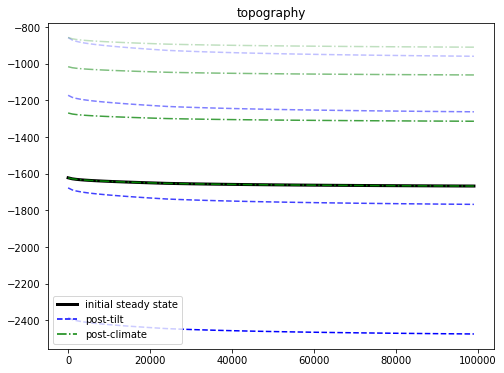

In [10]:
# check out topography
plt.figure(figsize = (8, 6))

plt.plot(x, eta_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x, eta_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x, eta_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x, eta_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x, eta_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x, eta_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x, eta_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x, eta_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x, eta_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('topography')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient topographic elevation.png')

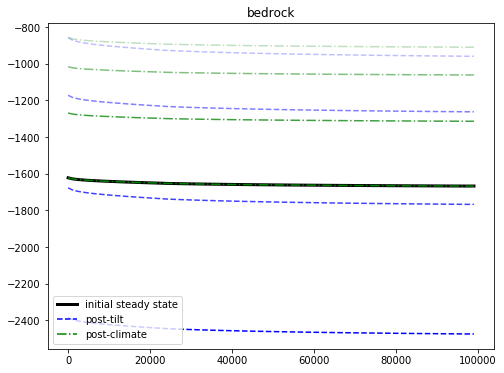

In [12]:
# check out bedrock
plt.figure(figsize = (8, 6))

plt.plot(x, etab_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x, etab_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x, etab_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x, etab_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x, etab_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x, etab_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x, etab_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x, etab_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x, etab_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('bedrock')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient bedrock elevation.png')

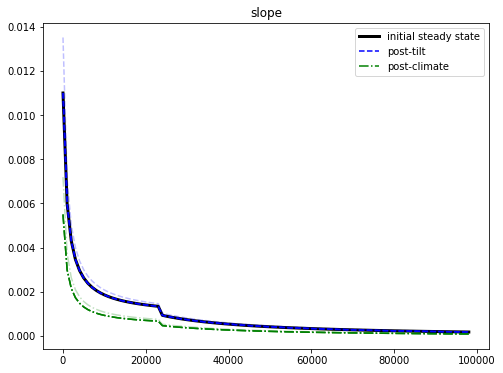

In [13]:
# check out slope
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], S_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x[:-1], S_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x[:-1], S_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x[:-1], S_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x[:-1], S_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x[:-1], S_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x[:-1], S_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x[:-1], S_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x[:-1], S_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('slope')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient slope.png')

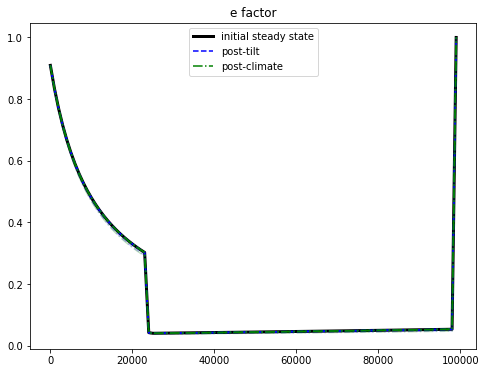

In [14]:
# check out e factor
plt.figure(figsize = (8, 6))

plt.plot(x, efac_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x, efac_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x, efac_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x, efac_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x, efac_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x, efac_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x, efac_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x, efac_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x, efac_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('e factor')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient e factor.png')

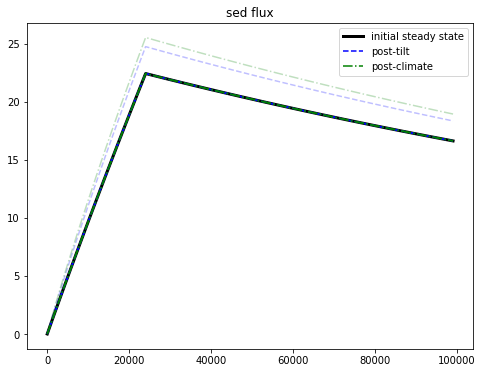

In [15]:
# check out qs
plt.figure(figsize = (8, 6))

plt.plot(x, qs_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x, qs_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x, qs_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x, qs_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x, qs_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x, qs_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x, qs_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x, qs_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x, qs_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('sed flux')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient sed flux.png')

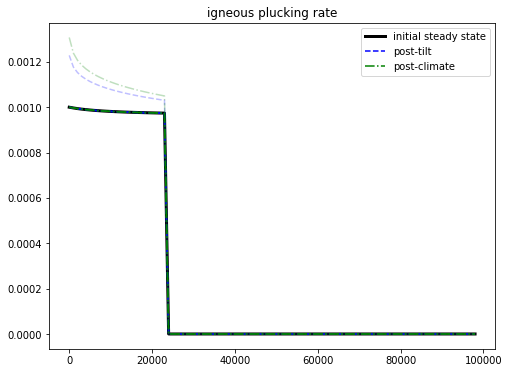

In [16]:
# check out igneous plucking
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], ero_plucking_ig_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x[:-1], ero_plucking_ig_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x[:-1], ero_plucking_ig_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x[:-1], ero_plucking_ig_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x[:-1], ero_plucking_ig_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x[:-1], ero_plucking_ig_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x[:-1], ero_plucking_ig_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x[:-1], ero_plucking_ig_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x[:-1], ero_plucking_ig_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('igneous plucking rate')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient igneous plucking rate.png')

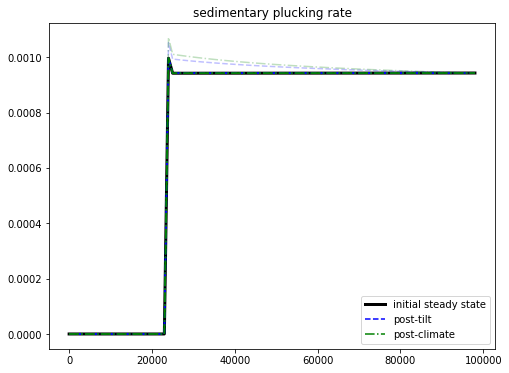

In [17]:
# check out sedimentary plucking
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], ero_plucking_sed_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x[:-1], ero_plucking_sed_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x[:-1], ero_plucking_sed_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x[:-1], ero_plucking_sed_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x[:-1], ero_plucking_sed_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x[:-1], ero_plucking_sed_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x[:-1], ero_plucking_sed_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x[:-1], ero_plucking_sed_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x[:-1], ero_plucking_sed_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('sedimentary plucking rate')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient sedimentary plucking rate.png')

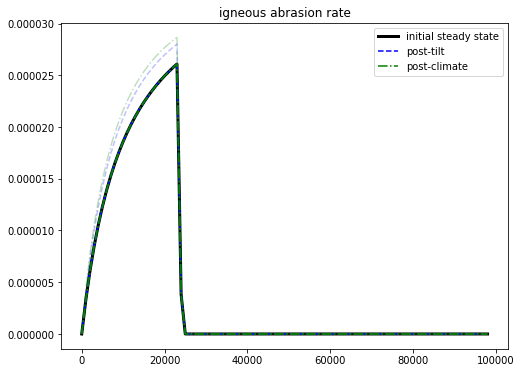

In [18]:
# check out igneous abrasion
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], ero_ab_ig_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x[:-1], ero_ab_ig_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x[:-1], ero_ab_ig_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x[:-1], ero_ab_ig_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x[:-1], ero_ab_ig_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x[:-1], ero_ab_ig_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x[:-1], ero_ab_ig_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x[:-1], ero_ab_ig_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x[:-1], ero_ab_ig_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('igneous abrasion rate')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient igneous abrasion rate.png')

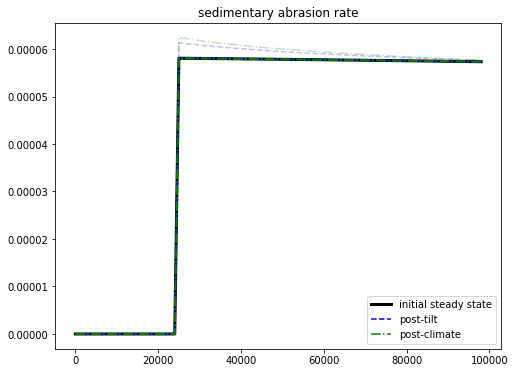

In [19]:
# check out sedimentary abrasion
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], ero_ab_sed_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x[:-1], ero_ab_sed_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x[:-1], ero_ab_sed_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x[:-1], ero_ab_sed_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x[:-1], ero_ab_sed_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x[:-1], ero_ab_sed_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x[:-1], ero_ab_sed_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x[:-1], ero_ab_sed_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x[:-1], ero_ab_sed_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('sedimentary abrasion rate')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient sedimentary abrasion rate.png')

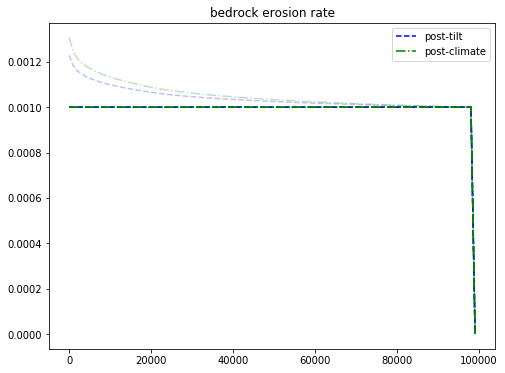

In [25]:
# check out bedrock erosion
plt.figure(figsize = (8, 6))

# plt.plot(x, bedrock_ero_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x, bedrock_ero_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x, bedrock_ero_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x, bedrock_ero_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x, bedrock_ero_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x, bedrock_ero_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x, bedrock_ero_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x, bedrock_ero_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x, bedrock_ero_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('bedrock erosion rate')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient bedrock erosion rate.png')

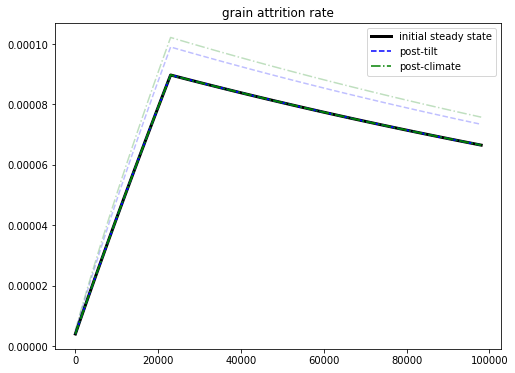

In [21]:
# check out grain attrition rate
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], atr_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x[:-1], atr_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x[:-1], atr_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x[:-1], atr_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x[:-1], atr_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x[:-1], atr_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x[:-1], atr_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x[:-1], atr_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x[:-1], atr_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('grain attrition rate')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient grain attrition rate.png')

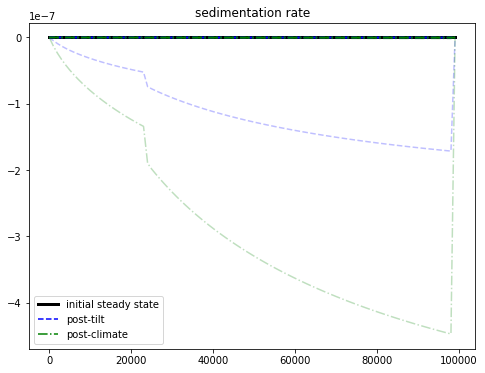

In [22]:
# check out sedimentation rate
plt.figure(figsize = (8, 6))

plt.plot(x, sedimentation_rate_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x, sedimentation_rate_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x, sedimentation_rate_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x, sedimentation_rate_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x, sedimentation_rate_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x, sedimentation_rate_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x, sedimentation_rate_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x, sedimentation_rate_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x, sedimentation_rate_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('sedimentation rate')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient sedimentation rate.png')

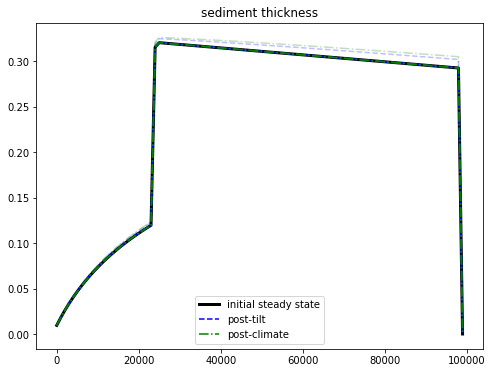

In [23]:
# check out sediment thickness
plt.figure(figsize = (8, 6))

plt.plot(x, H_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x, H_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x, H_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x, H_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x, H_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x, H_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x, H_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x, H_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x, H_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('sediment thickness')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient sediment thickness.png')

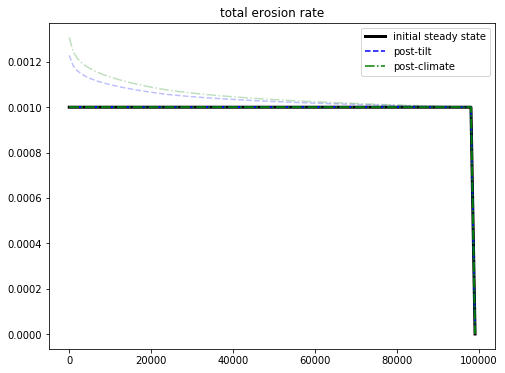

In [24]:
# check out total erosion rate
plt.figure(figsize = (8, 6))

plt.plot(x, total_ero_1, label = 'initial steady state', linewidth = 3, color = 'black')
plt.plot(x, total_ero_2_copy, linestyle = '--', color = 'blue', alpha = 0.25)
plt.plot(x, total_ero_3_copy, linestyle = '--', color = 'blue', alpha = 0.5)
plt.plot(x, total_ero_4_copy, linestyle = '--', color = 'blue', alpha = 0.75)
plt.plot(x, total_ero_5_copy, label = 'post-tilt', linestyle = '--', color = 'blue', alpha = 1)
plt.plot(x, total_ero_6_copy, linestyle = '-.', color = 'green', alpha = 0.25)
plt.plot(x, total_ero_7_copy, linestyle = '-.', color = 'green', alpha = 0.5)
plt.plot(x, total_ero_8_copy, linestyle = '-.', color = 'green', alpha = 0.75)
plt.plot(x, total_ero_9_copy, label = 'post-climate', linestyle = '-.', color = 'green', alpha = 1)
plt.title('total erosion rate')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/transient total erosion rate.png')